**Segmentation based on morphogenie**

http://morphogenie.fr/segmenting-nuclei.html

In [1]:
import skimage.io as io
io.use_plugin('tifffile')

#I updated "skimage.filter" to the more recent plural "skimage.filters"
from skimage.filters import threshold_otsu, threshold_adaptive, rank
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.morphology import disk, watershed
import pandas as pd
import numpy as np #added to morphogenie code
import mahotas as mh  #Don't know if this is used?
import matplotlib.pyplot as plt #added to morphogenie code

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
from scipy import fftpack
from matplotlib.colors import LogNorm
import math

In [2]:
#I adjusted the morphogenie code to import the full stack, and then focus on the Hoechst Channel for segmentation.
im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_2_Box1.tif')

image_stack = im[:,:,:,0]

z_size, x_size, y_size = image_stack.shape

z_scale = 0.26 # µm per plane for 100x NIC confocal images
xy_scale = 0.065 # µm per pixel for 100x NIC confocal images

In [3]:
%matplotlib inline

**Find a better threshold method**

In [4]:
smoothed_stack = np.zeros_like(image_stack)
labeled_stack = smoothed_stack.copy()

## Labeling for each z plane:
for z, frame in enumerate(image_stack):
    smoothed = mh.gaussian_filter(frame, 8.)
    smoothed_stack[z] = smoothed
    T_mean = smoothed.mean()
    bin_image = smoothed > T_mean
    labeled, nr_objects = mh.label(bin_image)
    #print(nr_objects)
    labeled_stack[z] = labeled

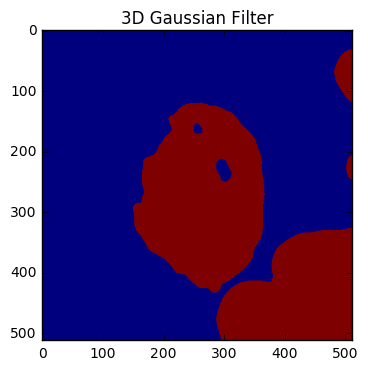

In [5]:
##3D Gaussian Filter
from scipy.ndimage import gaussian_filter
smoothed_stack=gaussian_filter(image_stack, 6.)
ss_mean = smoothed_stack.mean()
mask = smoothed_stack > ss_mean
plt.imshow(mask[3])
plt.title('3D Gaussian Filter')

**Fill Holes**

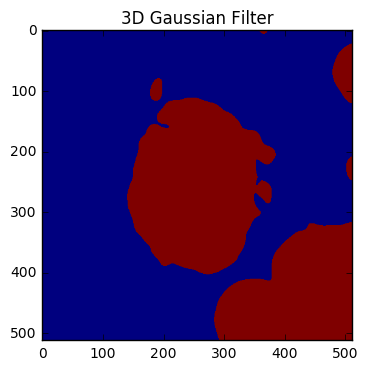

In [6]:
full_mask_stack = np.zeros_like(mask)

from scipy.ndimage import morphology
## Labeling for each z plane:
for z, frame in enumerate(mask):
    full_mask = morphology.binary_fill_holes(frame).astype(int)
    full_mask_stack[z] = full_mask

plt.imshow(full_mask_stack[20])
plt.title('3D Gaussian Filter')

**Watershed**

In [7]:
from skimage.morphology import watershed

In [8]:
##Test case
distance = ndimage.distance_transform_edt(full_mask_stack[20])
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((20, 20)), labels=full_mask_stack[23])
markers = ndimage.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=full_mask_stack[23])


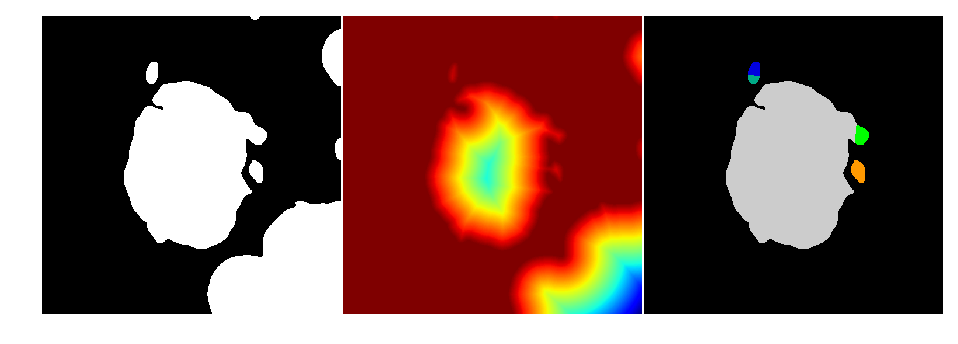

In [9]:
##Show the output
plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(full_mask_stack[23], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.imshow(labels, cmap='spectral', interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)
plt.show()

In [10]:
#Process stack
ws_stack = np.zeros_like(full_mask_stack)
## Watershed each z plane:
for z, frame in enumerate(full_mask_stack):
    distance = ndimage.distance_transform_edt(frame)
    local_maxi = peak_local_max(
        distance, indices=False, footprint=np.ones((20, 20)), labels=frame)
    markers = ndimage.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=frame)

    ws_stack[z] = labels

**Select Objects**

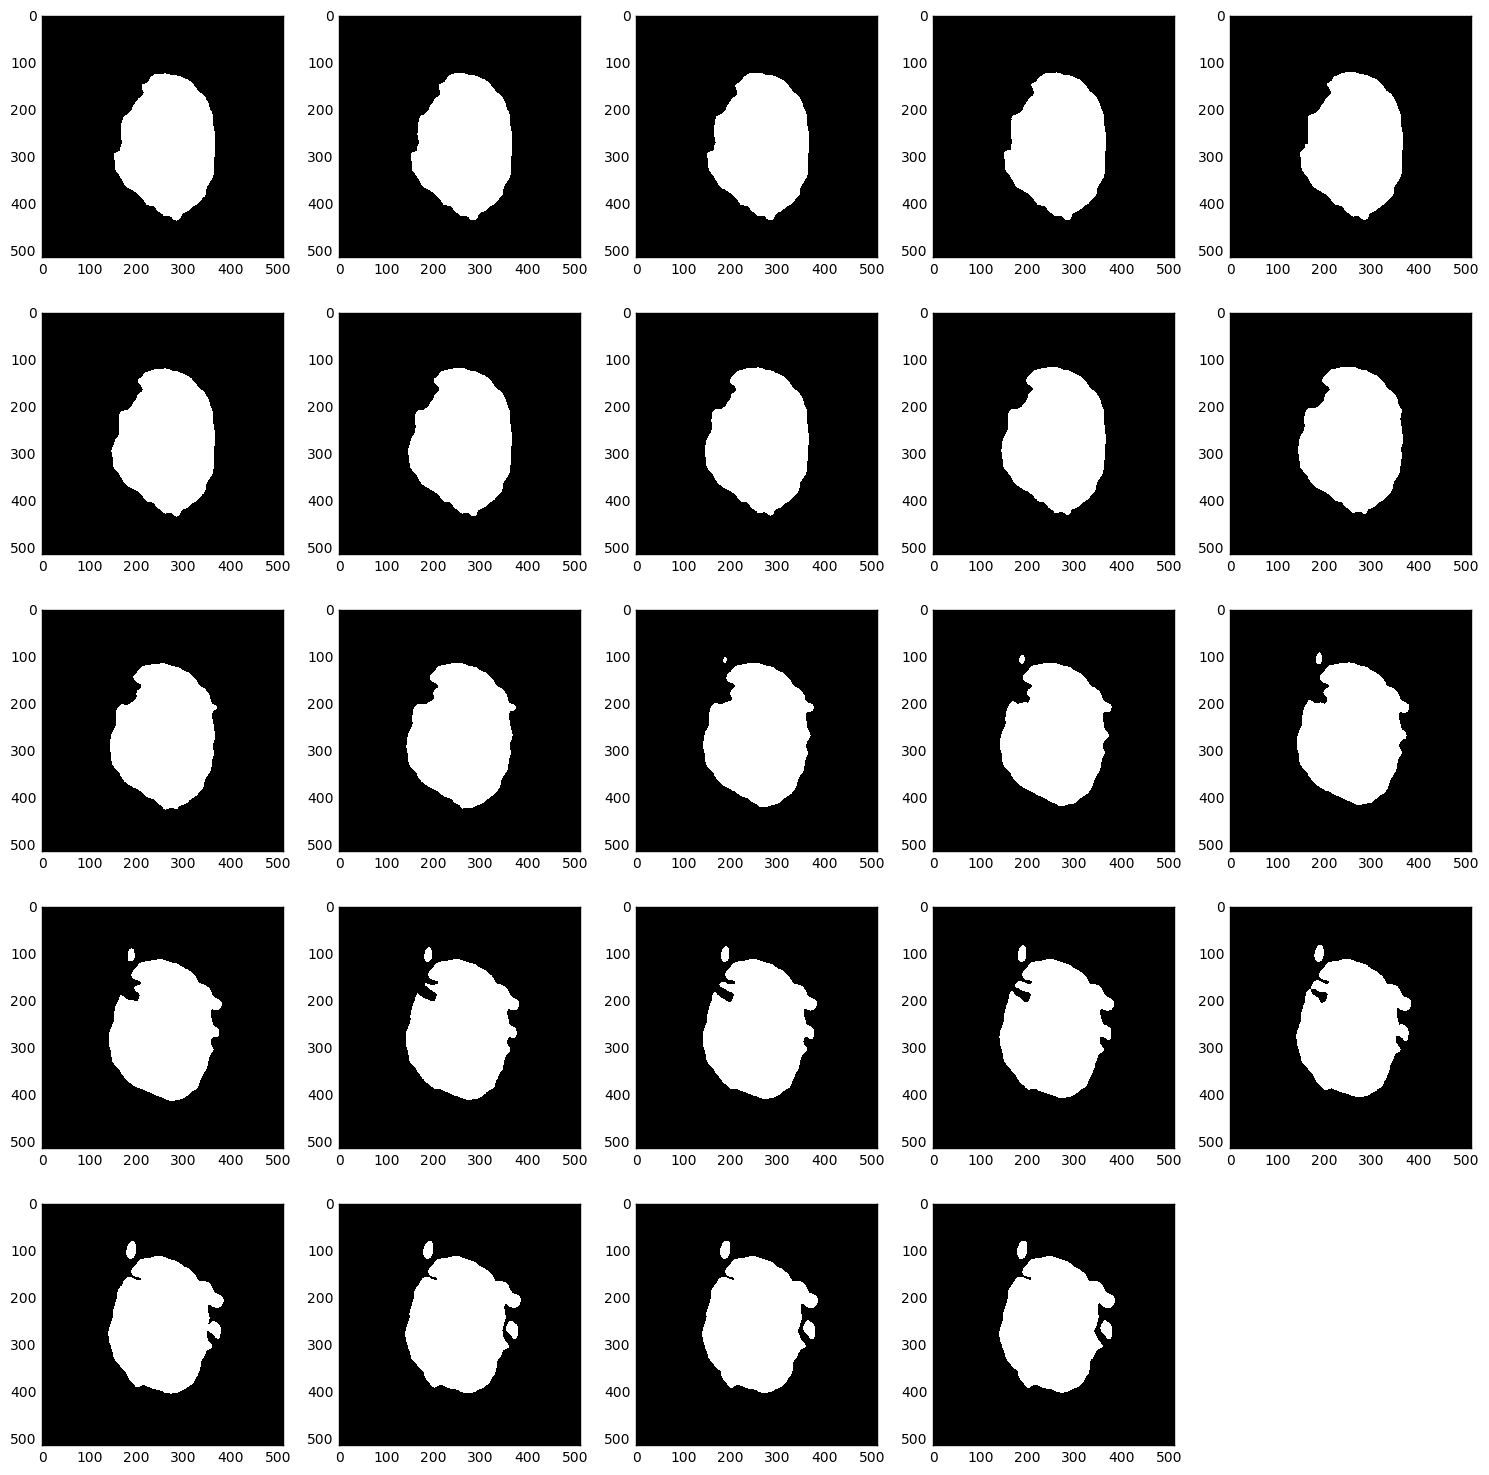

In [11]:
##Check the filtered stack
nrows = np.int(np.ceil(np.sqrt(z_size)))
ncols = np.int(z_size // nrows + 1)

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
for n in range(z_size):
    i = n // ncols
    j = n % ncols
    axes[i, j].imshow(ws_stack[n, ...],
                      interpolation='nearest', cmap='gray')
    
    
## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)
fig.tight_layout()

**Detection parameters**

We usually need some settings, derived from what we now of the objects we are trying to segment. 
We’ll also normaly do some kind of smoothing, which will be specified as the pixel size of the filter kernel. So here we go:

In [12]:
smooth_sizesmooth_s  = 5 # pixels
min_radius = 50
max_radius = 500

In [13]:
##'approximate_polygon' may be a simple way to simplify and smooth the detected objects.

contours, hierarchy = cv2.findContours(binaryimage,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

for ind, cont in enumerate(contours):
    elps = cv2.fitEllipse(cont)
    #Feed elps directly into cv2.ellipse
    cv2.ellipse(displayframe,elps,(0,0,255))

cv2.imshow("Perfectly fitted ellipses", displayframe)

NameError: name 'cv2' is not defined

**Computing the properties of the labeled regions:**

We use skimage.measure handy function regionprops. For convinience, we store the computed properties in a pandas DataFrame object (this is particullarly usefulll if you have more images or more timepoints, and want to later on manipulate the collected data.

In [14]:
labeled_stack=ws_stack

properties = []
columns = ('x', 'y', 'z', 'I', 'w')
indices = []
for z, frame in enumerate(labeled_stack):
    f_prop = regionprops(frame.astype(np.int),
                         intensity_image=image_stack[z])
    for d in f_prop:
        radius = (d.area / np.pi)**0.5
        if (min_radius  < radius < max_radius):
            properties.append([d.weighted_centroid[0],
                               d.weighted_centroid[1],
                               z, 
                               d.mean_intensity * d.area,
                               radius])
            indices.append(d.label)
if not len(indices):
    all_props = pd.DataFrame([], index=[])
indices = pd.Index(indices, name='label')
properties = pd.DataFrame(properties, index=indices, columns=columns)
#properties['I'] /= properties['I'].max() #This will normalise the intensities to the brightest.

In [15]:
properties.head(25)

,x,y,z,I,w
label,,,,,
1,279.893074,268.865141,0,7506533.0,123.864993
1,279.597161,268.651366,1,7545222.0,123.992134
1,279.179555,268.277278,2,7611192.0,124.238338
1,278.677539,267.594282,3,7705903.0,124.642491
1,278.044756,266.718991,4,7794766.0,125.203063
1,277.239906,265.650442,5,7867874.0,125.840839
1,276.267217,264.632589,6,7919909.0,126.333122
1,275.244941,263.861444,7,7953385.0,126.721803
1,273.978804,262.985797,8,7989814.0,127.000316


**Clustering**

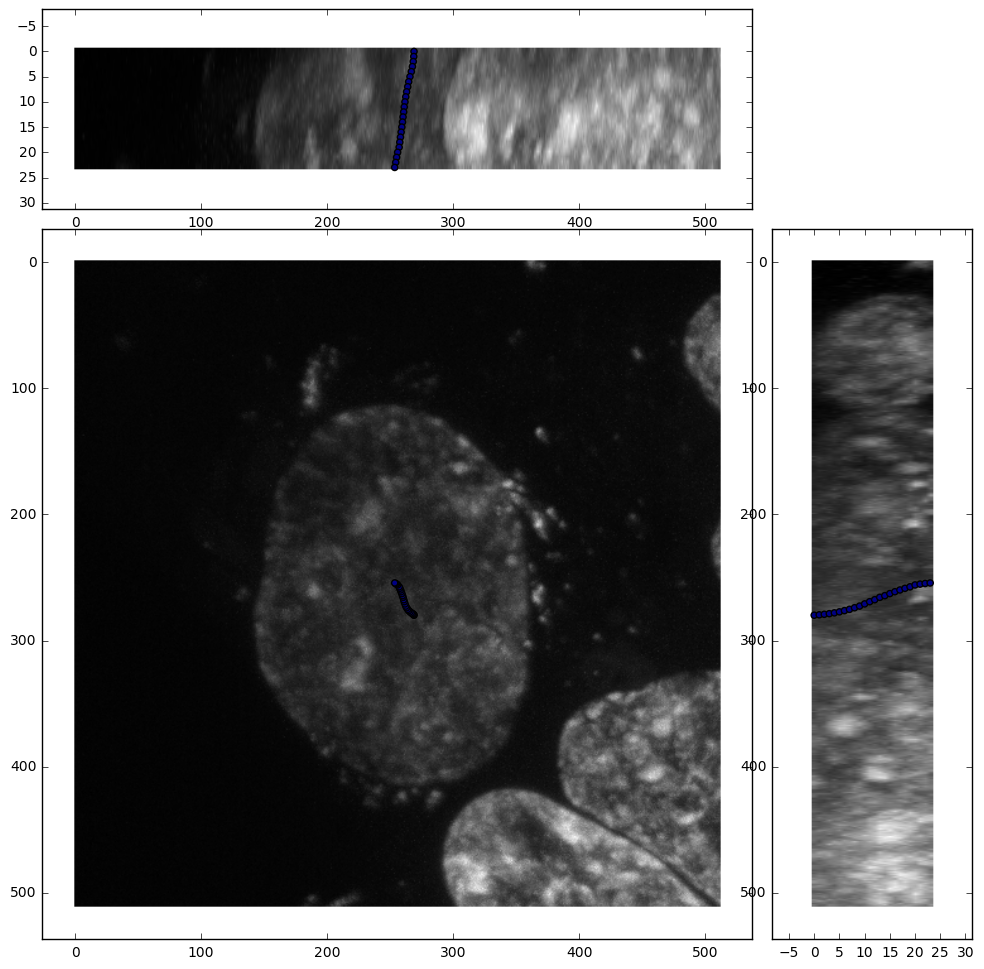

In [16]:
fig = plt.figure(figsize=(12, 12))
colors = plt.cm.jet(properties.index.astype(np.int32))

# xy projection:
ax_xy = fig.add_subplot(111)
ax_xy.imshow(image_stack.max(axis=0), cmap='gray')
ax_xy.scatter(properties['y'],
              properties['x'], c=colors, alpha=1)

divider = make_axes_locatable(ax_xy)
ax_zx = divider.append_axes("top", 2, pad=0.2, sharex=ax_xy)
ax_zx.imshow(image_stack.max(axis=1), aspect=z_scale/xy_scale, cmap='gray')
ax_zx.scatter(properties['y'],
              properties['z'], c=colors, alpha=1)
ax_yz = divider.append_axes("right", 2, pad=0.2, sharey=ax_xy)
ax_yz.imshow(image_stack.max(axis=2).T, aspect=xy_scale/z_scale, cmap='gray')
ax_yz.scatter(properties['z'],
              properties['x'], c=colors, alpha=1)
plt.draw()

Next we want to get the center of each cluster. 

To do so we run a weighted average of the positions for each cluster, using the measured intensity as weight.

In [18]:
def df_average(df, weights_column):
    '''Computes the average on each columns of a dataframe, weighted
    by the values of the column `weight_columns`.
    
    Parameters:
    -----------
    df: a pandas DataFrame instance
    weights_column: a string, the column name of the weights column 
    
    Returns:
    --------
    
    values: pandas DataFrame instance with the same column names as `df`
        with the weighted average value of the column
    '''
    
    values = df.copy().iloc[0]
    norm = df[weights_column].sum()
    for col in df.columns:
        try:
            v = (df[col] * df[weights_column]).sum() / norm
        except TypeError:
            v = df[col].iloc[0]
        values[col] = v
    return values

In [19]:
cell_positions = properties.groupby(level='label').apply(df_average, 'I')

In [20]:
#In this case there is only 1 nucleus
cell_positions

1,x,y,z,I,w
label,,,,,
1,267.736295,261.268754,11.606098,7.920985e+06,126.414146


In [96]:
##Calculate Nuclear Intensity
properties = []
columns = ('x','y','z', 'w', 'mean_GFP','I_GFP')
indices = []
for z, frame in enumerate(labeled_stack):
    f_prop = regionprops(frame.astype(np.int),
                         intensity_image=im[z,:,:,1]) #1=GFP
    for d in f_prop:
        radius = (d.area / np.pi)**0.5
        if (min_radius  < radius < max_radius):
            properties.append([d.weighted_centroid[0],
                               d.weighted_centroid[1],
                               z, 
                               radius,
                               d.mean_intensity,
                               d.mean_intensity * d.area])
            indices.append(d.label)
        if not len(indices):
            all_props = pd.DataFrame([], index=[])
            indices = pd.Index(indices, name='label')
properties = pd.DataFrame(properties, index=indices, columns=columns)

In [97]:
properties.head(24)

,x,y,z,w,mean_GFP,I_GFP
1,280.604484,266.065015,0,123.864993,1622.776307,78217818.0
1,279.481542,266.124119,1,123.992134,1754.032651,84718023.0
1,278.498451,265.770273,2,124.238338,1851.271349,89769999.0
1,277.265429,265.251070,3,124.642491,1958.650091,95595835.0
1,276.245522,264.566897,4,125.203063,2012.137267,99091724.0
1,274.890755,263.599866,5,125.840839,2074.780523,103220331.0
1,273.511594,262.511033,6,126.333122,2122.818568,106438123.0
1,272.369990,261.456326,7,126.721803,2144.586910,108192265.0
1,270.890964,260.181976,8,127.000316,2178.610369,110392366.0
1,269.570866,258.828475,9,127.169383,2194.814963,111509769.0


In [22]:
#Add I_Hoechst
I_Hoechst=[]
for z, frame in enumerate(labeled_stack):
    h_prop = regionprops(frame.astype(np.int),
                         intensity_image=im[z,:,:,0]) #0=Hoechst
    for d in h_prop:
        radius = (d.area / np.pi)**0.5
        if (min_radius  < radius < max_radius):
            I_Hoechst.append(d.mean_intensity * d.area)
            indices.append(d.label)
properties['I_Hoechst']=I_Hoechst

In [114]:
properties

,x,y,z,w,I_GFP,I_Hoechst
1,280.604484,266.065015,0,123.864993,78217818.0,7506533.0
1,279.481542,266.124119,1,123.992134,84718023.0,7545222.0
1,278.498451,265.770273,2,124.238338,89769999.0,7611192.0
1,277.265429,265.251070,3,124.642491,95595835.0,7705903.0
1,276.245522,264.566897,4,125.203063,99091724.0,7794766.0
1,274.890755,263.599866,5,125.840839,103220331.0,7867874.0
1,273.511594,262.511033,6,126.333122,106438123.0,7919909.0
1,272.369990,261.456326,7,126.721803,108192265.0,7953385.0
1,270.890964,260.181976,8,127.000316,110392366.0,7989814.0
1,269.570866,258.828475,9,127.169383,111509769.0,8011735.0


In [23]:
#Calculate total GFP
Nuclear_GFP=properties['I_GFP'].sum()
print(Nuclear_GFP)

#Calculate total GFP
Nuclear_Hoechst=properties['I_Hoechst'].sum()
print(Nuclear_Hoechst)

2491668436.0
190026778.0


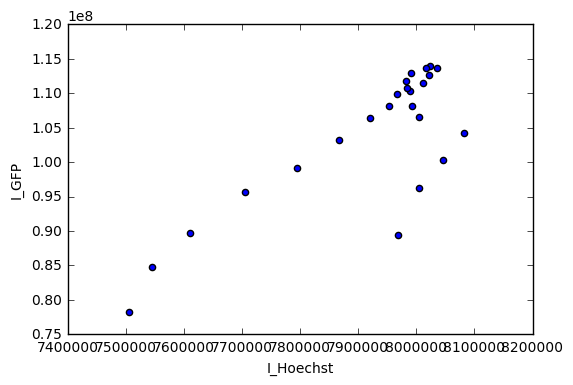

In [24]:
#Compare intensity across z-stacks
properties.plot.scatter('I_Hoechst','I_GFP')

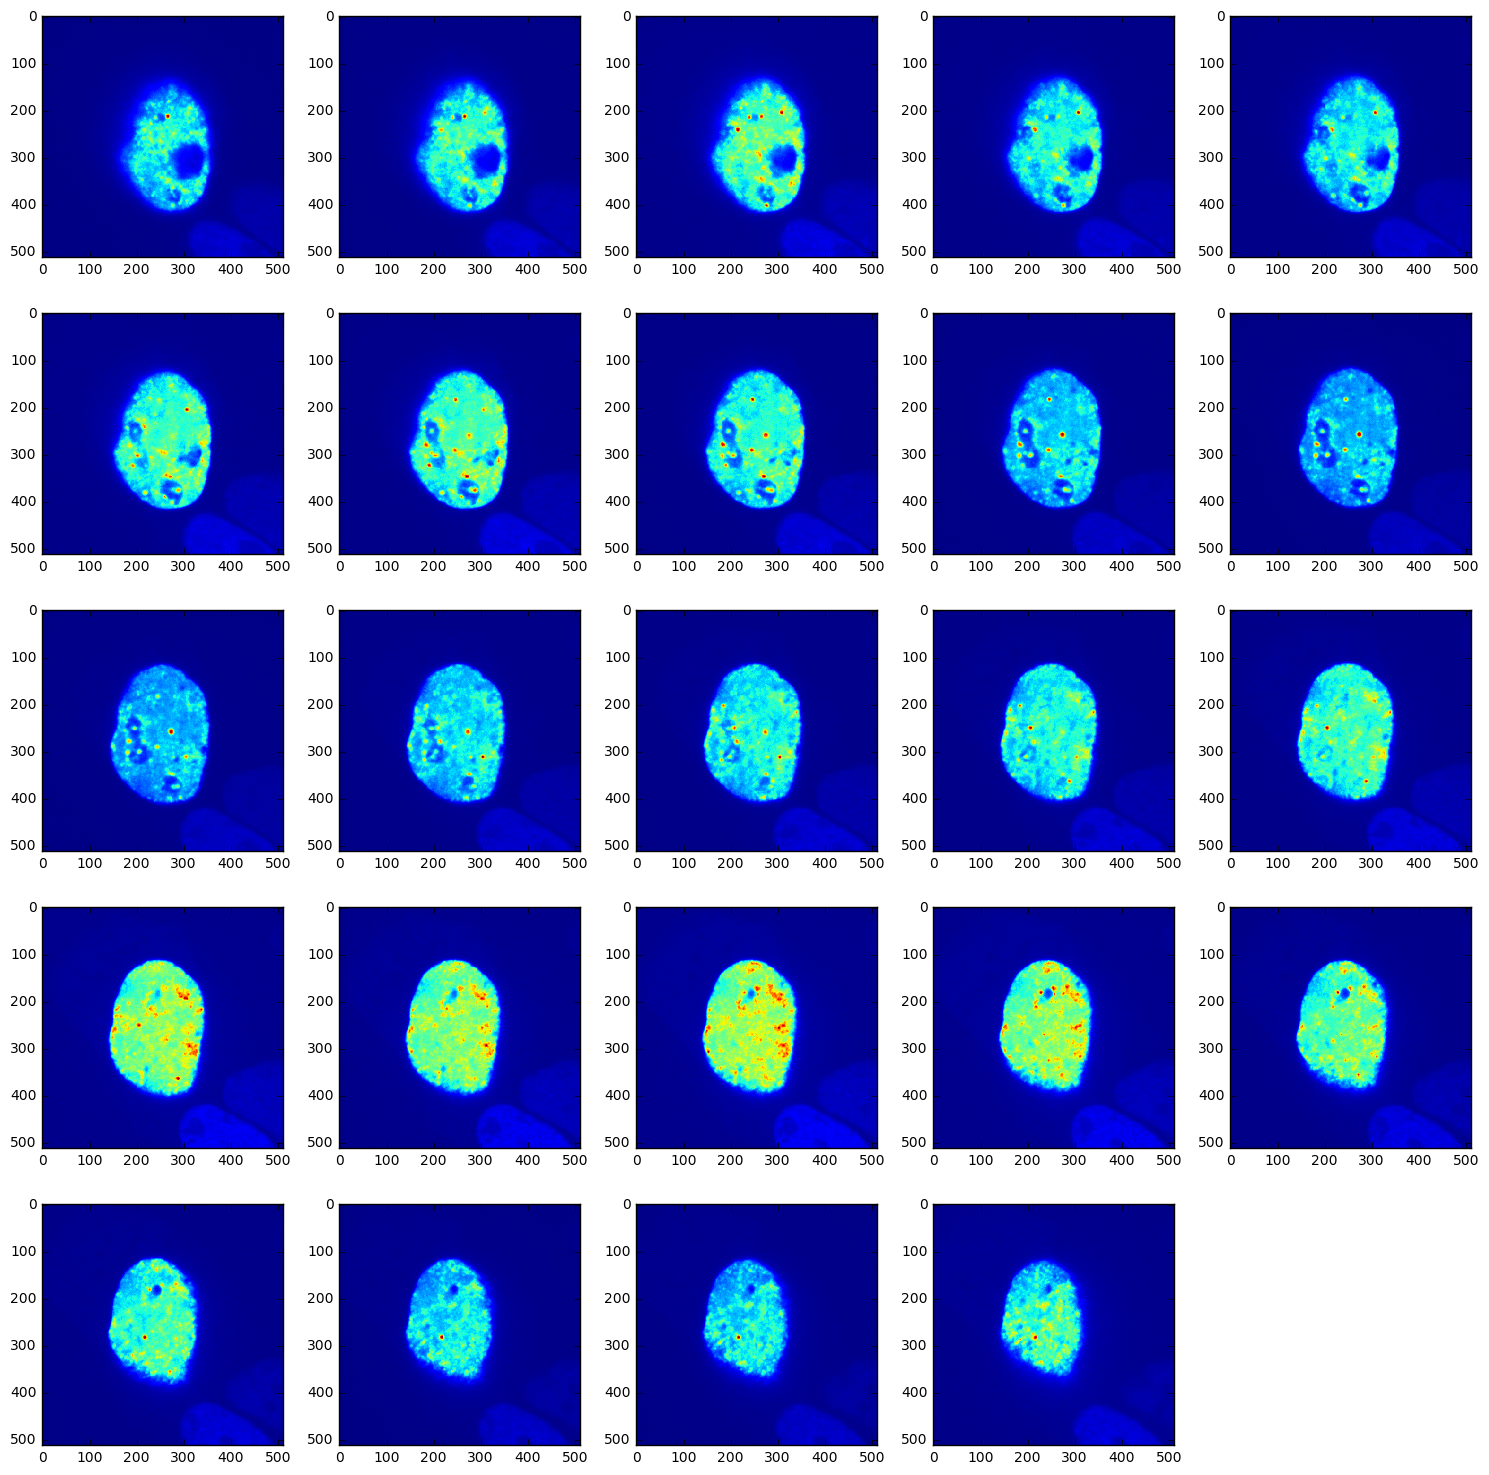

In [40]:
##Lets look at the GFP channel
GFP_stack=im[:,:,:,1]

nrows = np.int(np.ceil(np.sqrt(z_size)))
ncols = np.int(z_size // nrows + 1)

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
for n in range(z_size):
    i = n // ncols
    j = n % ncols
    axes[i, j].imshow(GFP_stack[n],
                      interpolation='nearest', 
                      #cmap='gray'
                     )
    
    
## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)
fig.tight_layout()

In [38]:
from skimage.feature import blob_log

In [73]:
#Detect maxima using 'blob_log' for more accurate detection. (Error messages suggest it only works on 2D arrays!!)
#Can't seem to get it to work at all
blobs = blob_log(GFP_stack[0], threshold=.01)

punc_fig = plt.figure(figsize=(12, 12))

colors = plt.cm.jet(blobs[:,2].astype(np.int32))

plt.imshow(GFP_stack[0], cmap='gray')
plt.scatter(blobs[:,0],
              blobs[:,1], c=colors, alpha=1)

array([[ 231.        ,  269.        ,   50.        ],
       [ 323.        ,  346.        ,    6.44444444],
       [ 365.        ,  270.        ,   44.55555556],
       [ 375.        ,  333.        ,    6.44444444]])

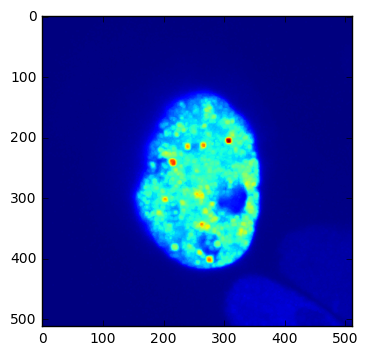

In [171]:
#Measure maxima intensities and count (bear in mind that we need to cluster to prevent over estimates)
#Max filter makes local maxima more obvious.
image_max=ndimage.maximum_filter(GFP_stack,footprint=np.ones((3,3,3)))
plt.imshow(image_max[3])

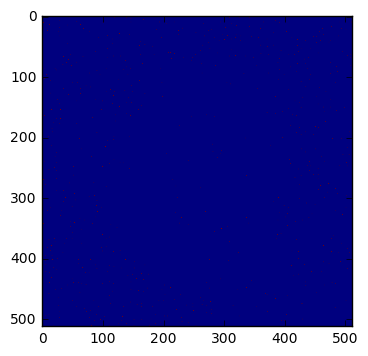

In [168]:
#local_max = ndimage.maximum_filter(GFP_stack, size=2.5)==GFP_stack
local_max = ndimage.maximum_filter(GFP_stack,footprint=np.ones((3,10,10)))==GFP_stack
plt.imshow(local_max[3]) #individual voxels are too small to see
##these are your markers

In [ ]:
##Identify local maxima within the nucleus
nu_pun=np.array(image_max) & np.array(ws_stack)
plt.imshow(nu_pun[3])
#plt.title('Puncta within the Nucleus')


##Get coordinates of local maxima
nu_max=np.array(local_max) & np.array(ws_stack)
plt.imshow(nu_pun[3])
#plt.title('Puncta within the Nucleus') #Voxels are hard to see on plot

In [ ]:
##Create mask
pT=image_max.mean()
puncta=image_max>pT
plt.imshow(puncta[12])

In [ ]:
markers=nu_max
spot_distance = ndimage.distance_transform_edt(image_max)
##
punc_labels = watershed(-distance,image_max, markers)
plt.imshow(punc_labels[3])

In [ ]:
from skimage import segmentation
markers=nu_max
##
punc_labels = segmentation.random_walker(image_max, markers)
plt.imshow(punc_labels[3])

IndexError: too many indices for array

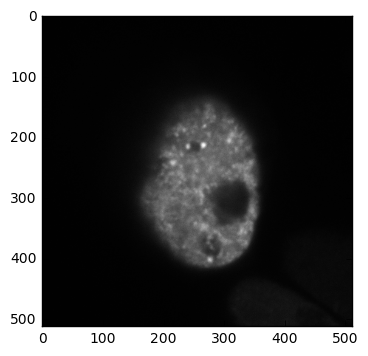

In [115]:
# xy projection:
plt.imshow(GFP_stack[1], cmap='gray')
plt.scatter(coordinates[1,:,0],
              coordinates[1,:,1], c=colors, alpha=1)

In [99]:
##Why not just threshold
pT=threshold_otsu(GFP_stack)

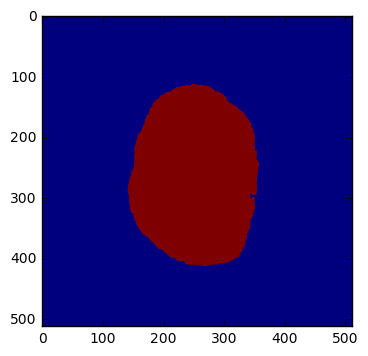

In [109]:
#pT=5*image_max.mean()
#pT=2500
puncta=image_max>pT
plt.imshow(puncta[12])

In [102]:
##Try working with a masked array
import numpy.ma as MA

In [107]:
pT=threshold_otsu(GFP_ma)

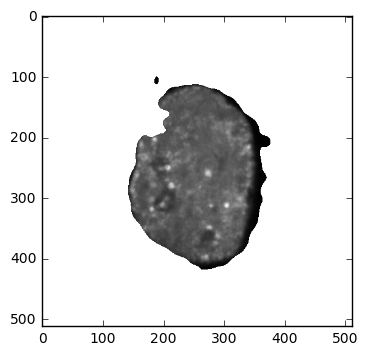

In [106]:
GFP_ma=MA.masked_array(GFP_stack,
                      mask=~ws_stack)

plt.imshow(GFP_ma[12],
           cmap='gray')

In [110]:
GFP_ma.mean()

2068.4784333258617

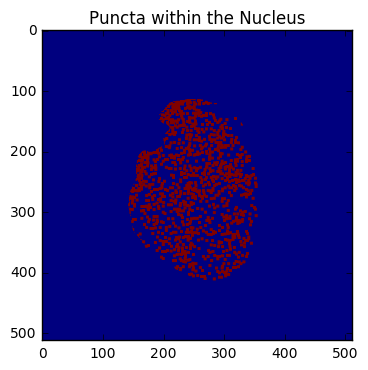

In [241]:
#Consider puncta within the nucleus. NB some puncta were cropped.
nu_pun=np.array(puncta) & np.array(ws_stack)
plt.imshow(nu_pun[11])
plt.title('Puncta within the Nucleus')

**Watershed Puncta**

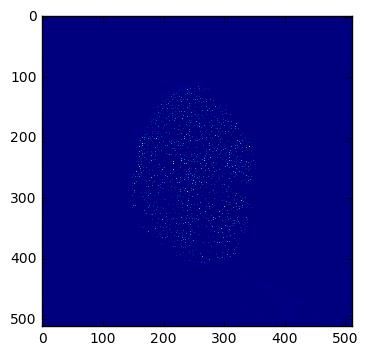

In [342]:
spot_distance = ndimage.distance_transform_edt(nu_pun)
#plt.imshow(spot_distance[11])


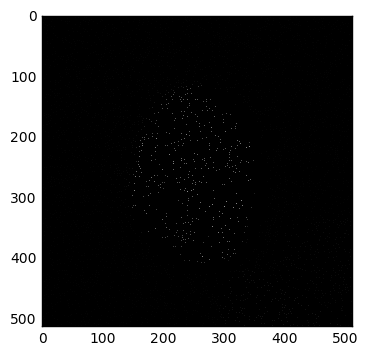

In [346]:
plt.imshow(im[11,:,:,1],interpolation='nearest', cmap='gray')

In [ ]:
    distance = ndimage.distance_transform_edt(frame)
    local_maxi = peak_local_max(
        distance, indices=False, footprint=np.ones((20, 20)), labels=frame)
    markers = ndimage.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=frame)

    ws_stack[z] = labels

**Label  and Cluster puncta**

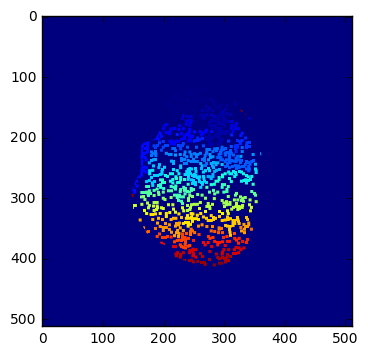

In [286]:
#Labelling works with 3D arrays, so connectivity is already estabilshed
labeled_spots, nr_objects = mh.label(nu_pun)
labeled_spots
plt.imshow(labeled_spots[5])

In [256]:
labeled_spots.shape

(24L, 512L, 512L)

**Measure puncta**

In [337]:
spot_properties=[]
columns = ('z','x','y','a','w','I')
spot_indices = []

g_prop=regionprops(labeled_spots.astype(np.int),
            intensity_image=im[:,:,:,1])
for d in g_prop:
    spot_properties.append([d.coords[:,0].mean(), #average the z-coordinates for voxels in this spot (frame)
                            d.coords[:,1].mean(), #average the x-coordinates for voxels in this spot (column)
                            d.coords[:,2].mean(), #average the y-coordinates for voxels in this spot (row)
                            d.area,
                            (d.area / np.pi)**0.5,
                            d.mean_intensity * d.area]) #area is just number of connected voxels)
    spot_indices.append(d.label)
spot_properties = pd.DataFrame(spot_properties, index=spot_indices, columns=columns)

In [338]:
spot_properties

,z,x,y,a,w,I
1,12.740970,145.324770,233.690885,53210,130.143264,5258295.0
2,13.920091,121.647641,270.049467,1314,20.451386,76424.0
3,11.500000,139.000000,239.000000,600,13.819766,55850.0
4,11.500000,146.481013,285.588608,3792,34.742353,334777.0
5,7.549645,146.093972,317.581560,564,13.398760,9228.0
6,11.500000,149.000000,304.000000,600,13.819766,36155.0
7,11.500000,154.234694,274.265306,2352,27.361741,228906.0
8,11.500000,186.895753,288.969112,24864,88.963234,3054862.0
9,11.500000,157.000000,264.000000,600,13.819766,54318.0
10,11.500000,162.000000,303.000000,600,13.819766,41047.0


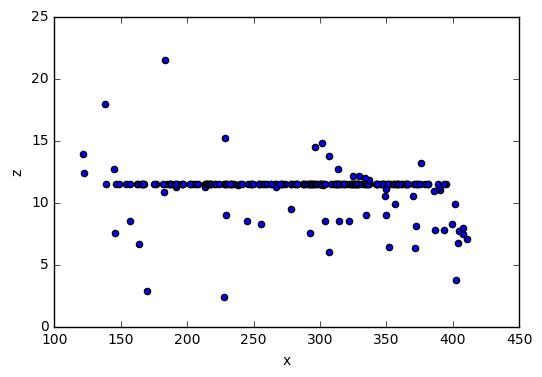

In [331]:
#Compare intensity across z-stacks
#spot_properties.plot.scatter('w','I')
spot_properties.plot.scatter('x','z')
#spot_properties['I'].plot.hist(bins=20)

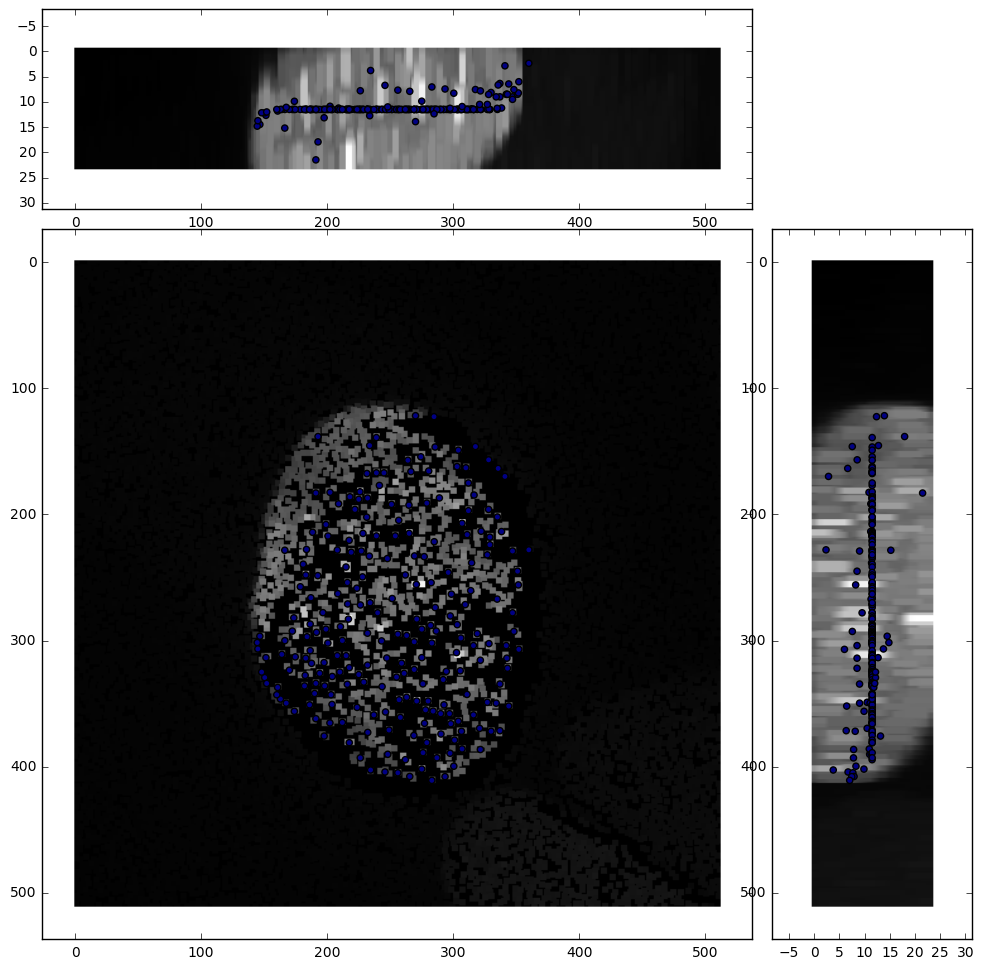

In [333]:
spot_fig = plt.figure(figsize=(12, 12))
colors = plt.cm.jet(properties.index.astype(np.int32))

# xy projection:
ax_xy = spot_fig.add_subplot(111)
ax_xy.imshow(image_max.max(axis=0), cmap='gray')
ax_xy.scatter(spot_properties['y'],
              spot_properties['x'], c=colors, alpha=1)

divider = make_axes_locatable(ax_xy)
ax_zx = divider.append_axes("top", 2, pad=0.2, sharex=ax_xy)
ax_zx.imshow(image_max.max(axis=1), aspect=z_scale/xy_scale, cmap='gray')
ax_zx.scatter(spot_properties['y'],
              spot_properties['z'], c=colors, alpha=1)
ax_yz = divider.append_axes("right", 2, pad=0.2, sharey=ax_xy)
ax_yz.imshow(image_max.max(axis=2).T, aspect=xy_scale/z_scale, cmap='gray')
ax_yz.scatter(spot_properties['z'],
              spot_properties['x'], c=colors, alpha=1)
plt.draw()

In [ ]:
##Simplify this shit
spot_properties = []
columns = ('x', 'y', 'z', 'I', 'w')
spot_indices = []
min_spot_r=0
max_spot_r=50

for z, frame in enumerate(labeled_spots):
    g_prop = regionprops(frame.astype(np.int),
                         intensity_image=im[z,:,:,1]) #GFP
    for d in g_prop:
        radius = (d.area / np.pi)**0.5
        if (min_spot_r  < radius < max_spot_r):
            spot_properties.append([d.weighted_centroid[0],
                               d.weighted_centroid[1],
                               z, 
                               d.mean_intensity * d.area,
                               radius])
            spot_indices.append(d.label)
        if not len(indices):
            all_props = pd.DataFrame([], index=[])
            spot_indices = pd.Index(indices, name='label')
spot_properties = pd.DataFrame(spot_properties, index=indices, columns=columns)
#properties['I'] /= properties['I'].max() #This will normalise the intensities to the brightest.

In [263]:
##Should really just call the same labelling function used for nuclei labelling again here
spot_properties = []
columns = ('x', 'y', 'z', 'I', 'w')
spot_indices = []
min_spot_r=0
max_spot_r=50

for z, frame in enumerate(labeled_spots):
    g_prop = regionprops(frame.astype(np.int),
                         intensity_image=im[z,:,:,1]) #GFP
    for d in g_prop:
        radius = (d.area / np.pi)**0.5
        if (min_spot_r  < radius < max_spot_r):
            spot_properties.append([d.weighted_centroid[0],
                               d.weighted_centroid[1],
                               z, 
                               d.mean_intensity * d.area,
                               radius])
            spot_indices.append(d.label)
        if not len(indices):
            all_props = pd.DataFrame([], index=[])
            spot_indices = pd.Index(indices, name='label')
spot_properties = pd.DataFrame(spot_properties, index=indices, columns=columns)
#properties['I'] /= properties['I'].max() #This will normalise the intensities to the brightest.

ValueError: Shape of passed values is (5, 5171), indices imply (5, 1)

**Cluster puncta**

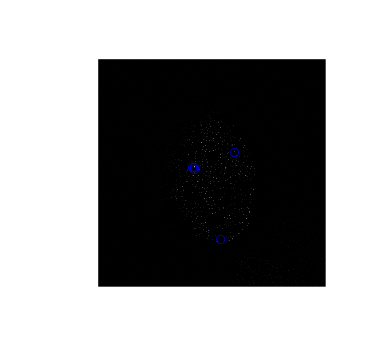

In [134]:
size=5
peak_threshold=5000

#Find puncta
image_max = ndimage.maximum_filter(im[3,:,:,1], size=size, mode='constant')
puncta = (im[3,:,:,1] == image_max) #What is happening here
im[:,:,:,1] *= puncta

# Find peaks
image_t = (im[3,:,:,1] > peak_threshold) * 1

# get coordinates of peaks
f = np.transpose(image_t.nonzero())

# Show
img = plt.imshow(np.asarray(im[3,:,:,1]), cmap='gray')
plt.plot(f[:, 1], f[:, 0], 'o', markeredgewidth=0.45, markeredgecolor='b', markerfacecolor='None')

plt.axis('off')
plt.savefig('local_max.png', format='png', bbox_inches='tight')
plt.show()                                